In [1]:
import gym
from Task3.model import ActorModel, CriticModel, Memory, PPO
import torch
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

cpu


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)


cpu


In [3]:
# define some hyperparameters from the paper of PPO
n_epochs = 10
gamma = 0.97
clip_ratio = 0.15
c_1 = 0.5
games = 100
fc_size = 128
T = 128
step = 0
wins = []
losses = []
reward_history = []

# create the environment from gym
env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape[-1]
action_space = env.action_space.n
# create the model
actor = ActorModel(observation_space, action_space, fc_size)
critic = CriticModel(observation_space, fc_size)
memory = Memory()
ppo = PPO(memory, actor, critic)

running_history = []
results = {}

save_path = os.path.join(os.curdir, 'saved_files/wins_losses.pickle')
if not os.path.exists(os.path.join(os.curdir, 'saved_files')):
    os.mkdir(os.path.join(os.curdir, 'saved_files'))

if os.path.exists(save_path):
    # load values
    with open(save_path, 'rb') as file2load:
        print('Loading previous values...')
        exp_results = pickle.load(file2load)
        print('Values Loaded')
else:
    ## main loop ##
    for g in range(games):
        # get initial state
        state = env.reset()
        # setup useful variables
        running_score = 0
        train_counter = 0
        done = False
        # iterate through the game util it's finished
        while not done:
            # env.render()
            np.random.seed(step)
            act_distr = actor(torch.tensor(state, dtype=torch.float))
            action = np.argmax(np.random.multinomial(1, np.array(act_distr.data)))
            new_state, reward, done, info = env.step(action)
            step += 1
            # update running score
            running_score += reward
            # compute log_probs of the prob distribution
            log_prob = np.log(act_distr.data[action]).item()
            # compute the value for this game iteration
            value = critic(torch.tensor(state, dtype=torch.float)).data.item()
            # store the info in the memory
            memory.push(state, action, reward, value, done, log_prob)
            # update policy once every T steps
            if step % T == 0:
                ppo(n_epochs, gamma, clip_ratio, c_1)
                train_counter += 1
            # update current state to new state
            state = new_state
            running_history.append(running_score)
            # by documentation, the problem is solved
            # if the average reward is greater than 195 over the last 100 trials
            # let't check this
            if step % 100 == 0:
                avg_reward = np.mean(running_history[-100:])
                reward_history.append(avg_reward)
                if avg_reward >= 195:
                    wins.append(avg_reward)
                else:
                    losses.append(avg_reward)
                print('Game completed: [{}]/[{}],'
                      ' Average reward of last 100 trials: {}'.format(g+1,
                                                                      games,
                                                                      avg_reward))
    print('Training Completed')
    file_name = 'wins_losses.pickle'
    print('Saving values...')
    results['Final_Results'] = {'wins': wins, 'losses': losses, 'reward_history': reward_history}
    with open(os.path.join(os.curdir, 'saved_files/'+file_name), 'wb') as file2store:
        pickle.dump(results, file2store, protocol=pickle.HIGHEST_PROTOCOL)
    print('Done!')

Game completed: [5]/[100], Average reward of last 100 trials: 12.03
Game completed: [9]/[100], Average reward of last 100 trials: 12.82
Game completed: [12]/[100], Average reward of last 100 trials: 23.8
Game completed: [14]/[100], Average reward of last 100 trials: 18.65
Game completed: [16]/[100], Average reward of last 100 trials: 25.44
Game completed: [17]/[100], Average reward of last 100 trials: 50.5
Game completed: [19]/[100], Average reward of last 100 trials: 47.01
Game completed: [21]/[100], Average reward of last 100 trials: 22.08
Game completed: [21]/[100], Average reward of last 100 trials: 73.5
Game completed: [22]/[100], Average reward of last 100 trials: 142.3
Game completed: [22]/[100], Average reward of last 100 trials: 65.5
Game completed: [24]/[100], Average reward of last 100 trials: 60.06
Game completed: [25]/[100], Average reward of last 100 trials: 47.46
Game completed: [26]/[100], Average reward of last 100 trials: 68.55
Game completed: [26]/[100], Average rewa

In [24]:
def plot_image(exp_results, exp_name='Final_Results'):
    n_experiments = len(exp_results[exp_name]['reward_history'])
    plt.figure(figsize=(10, 8))
    for i in range(n_experiments):
        plt.plot(exp_results[exp_name]['reward_history'][::2])
        plt.xscale('log')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.title('{} Results'.format(exp_name))

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

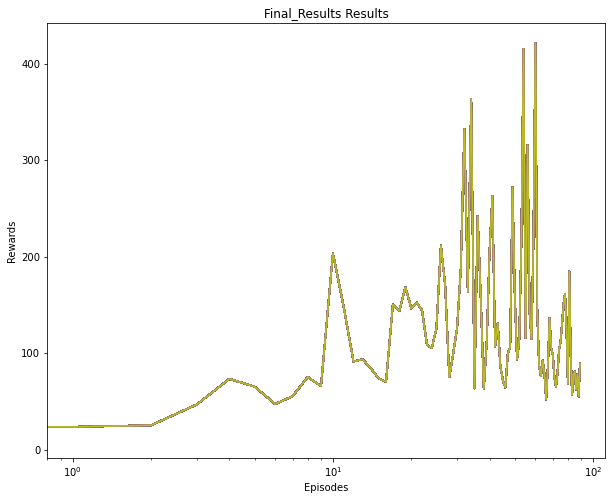

In [25]:
plot_image(results)
